### Импорт необходимых библиотек и загрузка датасета

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as op
import tensorflow as tf                                                               # библиотека Tensorflow
import keras                                                                          # библиотека Keras
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU, Rescaling     # cлои библиотеки Keras
from keras.layers import BatchNormalization, Conv2DTranspose, Concatenate             # cлои библиотеки Keras
from keras.models import Model, Sequential                                            # конструкторы построения моделей библиотеки Keras

from keras.optimizers import Adam                                                     # оптимизатор Adam
import tensorflow_datasets as tfds                                                    # датасеты от Tensorflow

import matplotlib.pyplot as plt                                                       # библиотека для рисования графиков
%matplotlib inline

Загрузим датасет с данными о радиографическом исследовании по COVID-19 c Kaggle.

In [ ]:
op.download("https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: asugyfuyasdgf
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database


100%|██████████| 778M/778M [00:36<00:00, 22.7MB/s]


Структура папок:

In [ ]:
dataset_path = './covid19-radiography-database/COVID-19_Radiography_Dataset/Normal'

image_dir = 'images'
label_dir = 'masks'

### Обработка данных

In [ ]:
# Функция нормализации входного изображения и маски
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0 # приводим данные к float32 и делим значение интенсивности пикселей на 255 для входного изображения
  input_mask -= 1                                        # маска имеет значения классов 1, 2 и 3, приведем ее к 0, 1, 2
  return input_image, input_mask                         # возвращаем преобразованные изображение и маску

In [ ]:
# Функция загрузки изображения
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (160, 160))             # изменяем размер изображения до 160 х 160
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (160, 160))  # изменяем размер маски до 160 х 160

  input_image, input_mask = normalize(input_image, input_mask)              # нормализуем изображение и маску

  return input_image, input_mask                                            # возвращаем преобразованные изображение и маску

In [ ]:
# Конвейеры преобразования входных наборов данных для обучающей и тестовой выборок
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(64).prefetch(1)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(64).prefetch(1)

### Визуализация отдельных образцов датасета

Выведем на экран несколько образцов изображений из датасета и соответствующие им сегментирующие маски.

In [ ]:
# Функция вывода изображений
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Изображение', 'Сегментирующая маска']             # определим заголовки графиков

  # В цикле выводим изображения из списка display_list
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)                    # выводим область для построения графика
    plt.title(title[i])                                       # выводим заголовок графика
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))  # преобразуем матрицу в изображение и выводим на экран
    plt.axis('off')                                           # отключаем отображение осей на графике
  plt.show()                                                  # выводим график целиком

In [ ]:
for images, masks in train_images.take(2):                    # берем 2 экземпляра из пакета и выводим с помощью функции display на экран
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

NameError: name 'train_images' is not defined

In [ ]:
original_image = os.path.join(dataset_path, image_dir, 'Normal-1.png')       # путь до ориганального изображения
label_image_semantic = os.path.join(dataset_path, label_dir, 'Normal-1.png') # путь до маски

fig, axs = plt.subplots(1, 2, figsize=(16, 8))                          # задаем область для построения (канвас)

img = np.array(load_img(original_image, target_size=(256, 256), color_mode='rgb'))   # загружаем оригинальное изображение как RGB с 3 каналами
mask = np.array(load_img(label_image_semantic, target_size=(256, 256), color_mode='grayscale'))  # загружаем маску как "отеннки серого", т.е. в один канал

axs[0].imshow(img)  # отрисовываем оригинальное изображение
axs[0].grid(False)

axs[1].imshow(mask) # отрисовываем маску (одноканальное изображение, каждый класс отображается как отдельный цвет)
axs[1].grid(False)

### Архитектура сети

В нашем примере мы возьмем измененную структуру U-net сети, отличную от описанной в оригинальной статье. Итак, что мы изменим и зачем:

1. Поданные на вход модели изображения будут преобразовываться к размеру 160 х 160 px. Размер изображений мы взяли, исходя из ограниченных ресурсов колаба.
2.  Для всех сверточных слоев `Conv2D` и «повышающих сверток» `Conv2DTranspose` мы будем использовать `padding="same"` из личных предпочтений, ведь так легче считать размерности матриц на выходе слоев. Нам необходимо понимать размеры матриц на входе и выходе каждого слоя, чтобы правильно применить латеральные соединения.  
3. Также тесты показали на данном датасете, что результат получается лучше если сделать небольшие изменения последнего слоя и использовать ядро `3x3` вместо `1x1`. И если сегментация подразумевает выделение нескольких областей на изображении, то последний слой использует функцию активации `softmax` вместо `sigmoid`. Как в нашем случае, датасет содержит 3 класса: сегментированный объект, выделительная рамка вокруг объекта и остальная область (назовем ее фон). Аналогичным подходом можно "выделять" несколько объектов на изображении, где каждый объект это свой класс. Это задача мультиклассовой сегментации и с ней мы познакомимся в следующей части урока.

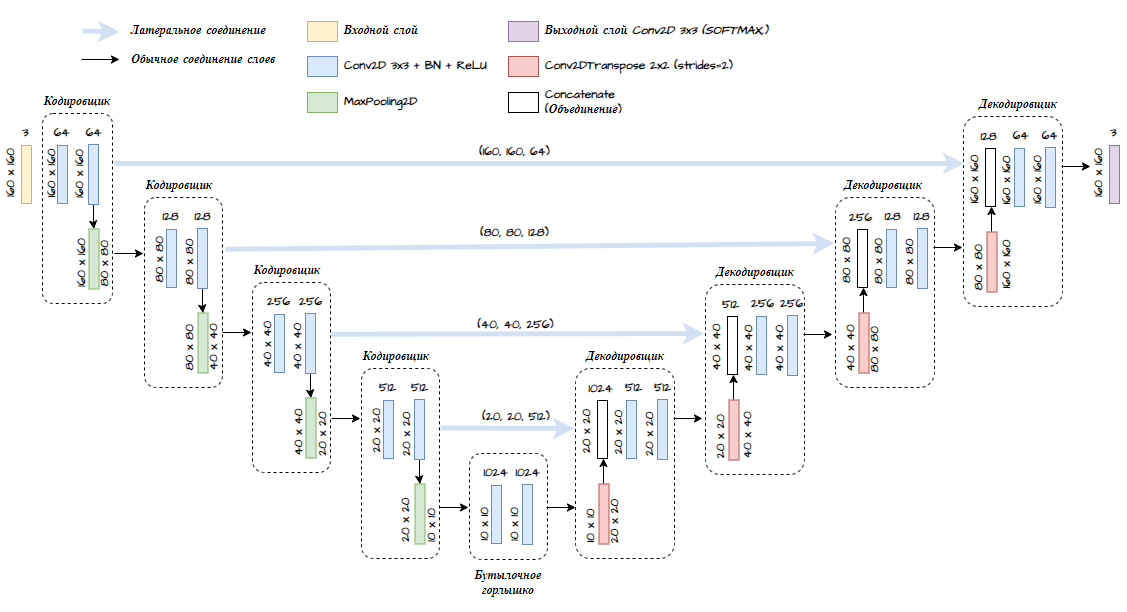

Рис. 2. Архитектура модели, которую будем обучать. Немного изменили обозначения для большей наглядности по сравнению с оригинальной статьей. Для всех слоев указываем размер матриц на выходе (вверху число карт признаков, сбоку размер карт признаков на выходе из слоя). Для слоев MaxPooling2D и Conv2DTranspose указываем 2 размера карт признаков: на входе (слева) и выходе (справа). На латеральных соединениях указана общая форма переносимой матрицы.

Теперь по данному графику архитектуры соберем всю модель.

Объявим функцию операции свертки, что на рис. 2 изображено как два последовательных синих блока.

In [ ]:
def convolution_operation(entered_input, filters=64):

    conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    acti1 = ReLU()(batch_norm1)


    conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(acti1)
    batch_norm2 = BatchNormalization()(conv2)
    acti2 = ReLU()(batch_norm2)

    return acti2

Далее объявим функции кодировщика и декодировщика согласно рис. 2.

In [ ]:
# Функция кодировщика
# На входе 2 параметра - предыдущий слой и число фильтров (генерируемых карт признаков)
def encoder(entered_input, filters=64):

    encod1 = convolution_operation(entered_input, filters)  # функция свертки - 2 синих блока
    MaxPool1 = MaxPooling2D(strides = (2,2))(encod1)        # зеленый блок
    return encod1, MaxPool1 # функция возвращает латеральное соединение и выход из слоя

# Функция декодировщика
# На входе 3 параметра - предыдущий слой и латеральное соединение и число фильтров (генерируемых карт признаков)
def decoder(entered_input, skip, filters=64):
    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input) # красный блок
    Connect_Skip = Concatenate()([Upsample, skip])                                        # белый блок (объединение латерального соединения и выхода предыдущего слоя)
    out = convolution_operation(Connect_Skip, filters)                                    # функция свертки - 2 синих блока
    return out # функция возвращает выход из слоя

Соберем сеть целиком.

In [ ]:
# Наша интерпретация модели U-net
def U_Net(img_size, num_classes):
    # Входной слой - желтый блок
    inputs = Input(img_size)

    # Задаем блоки кодировщика и латеральные соединения
    skip1, encoder_1 = encoder(inputs, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    skip4, encoder_4 = encoder(encoder_3, 64*8)

    # Бутылочное горлышка задаем 2-мя синими блоками
    conv_block = convolution_operation(encoder_4, 64*16)

    # Задаем блоки декодировщика и передаем ему латеральные соединения от кодировщиков
    decoder_1 = decoder(conv_block, skip4, 64*8)
    decoder_2 = decoder(decoder_1, skip3, 64*4)
    decoder_3 = decoder(decoder_2, skip2, 64*2)
    decoder_4 = decoder(decoder_3, skip1, 64)

    # Выходной слой (фиолетовый блок), его конфигурация зависит от решаемой задачи
    outputs = Conv2D(num_classes, kernel_size = (3, 3), padding="same", activation="softmax")(decoder_4)

    model = Model(inputs, outputs)
    return model

In [ ]:
num_classes = 3 # 3 класса: фон, сегментированый объект и рамка вокруг объекта
input_shape = (160, 160, 3) # размер к которому преобразуем изображение, 3 канала - RGB
model = U_Net(input_shape, num_classes) # инициализируем модель

In [ ]:
model.summary() # отчет о структуре модели

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 160, 160, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_18 (Ba  (None, 160, 160, 64)         256       ['conv2d_19[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_18 (ReLU)             (None, 160, 160, 64)         0         ['batch_normalization_18

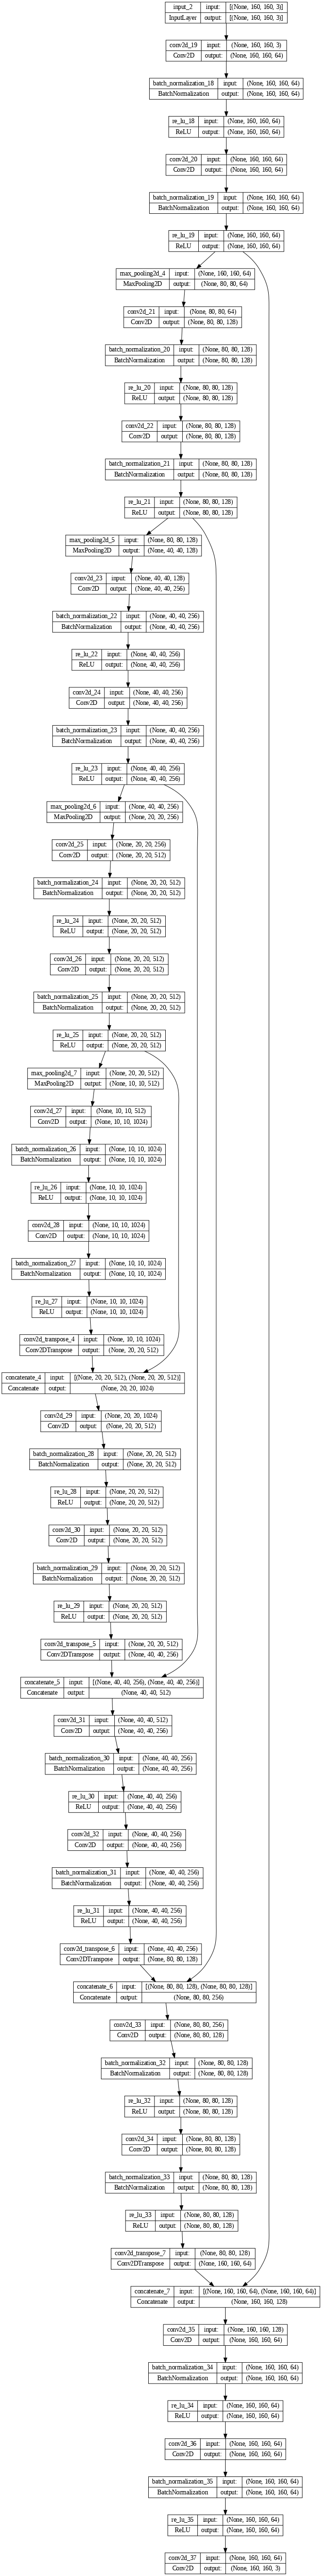

In [ ]:
# график структуры модели
tf.keras.utils.plot_model(model, "model.png", show_shapes=True, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=70)

### Обучение модели

В качестве функции ошибки возьмем разряженную перекрестную категориальную энтропию. Основная задача обучения - ее минимизация. В качестве метрики будем выводить точность. Обучать будем на 30 эпохах.

In [ ]:
model.compile(
    optimizer=Adam() ,
    loss="sparse_categorical_crossentropy",
    metrics=['sparse_categorical_accuracy']
)

callbacks = [
    keras.callbacks.ModelCheckpoint("segmentation.keras", save_best_only=True)
]

In [ ]:
epochs = 30
history = model.fit(train_images, epochs=epochs, validation_data=test_images, callbacks=callbacks)

Epoch 1/30
58/58 [==============================] - 134s 2s/step - loss: 0.7188 - sparse_categorical_accuracy: 0.6838 - val_loss: 8.8508 - val_sparse_categorical_accuracy: 0.4965
Epoch 2/30
58/58 [==============================] - 126s 2s/step - loss: 0.5559 - sparse_categorical_accuracy: 0.7666 - val_loss: 7.8717 - val_sparse_categorical_accuracy: 0.4076
Epoch 3/30
58/58 [==============================] - 134s 2s/step - loss: 0.4849 - sparse_categorical_accuracy: 0.7985 - val_loss: 1.3913 - val_sparse_categorical_accuracy: 0.6366
Epoch 4/30
58/58 [==============================] - 128s 2s/step - loss: 0.4316 - sparse_categorical_accuracy: 0.8213 - val_loss: 2.0936 - val_sparse_categorical_accuracy: 0.5164
Epoch 5/30
58/58 [==============================] - 122s 2s/step - loss: 0.3904 - sparse_categorical_accuracy: 0.8387 - val_loss: 0.7780 - val_sparse_categorical_accuracy: 0.7432
Epoch 6/30
58/58 [==============================] - 122s 2s/step - loss: 0.3579 - sparse_categorical_accu

### Анализ результатов обучения

Посмотрим на график точности и функции ошибки. Видно, что еще точность далека от насыщения и можно продолжать обучение. Переобучения пока нет. Обычно модели для семантической сегментации обучают на 100 эпохах с установленным коллбэком `EarlyStopping` для ранней остановки обучения, если модель перестала улучшаться.

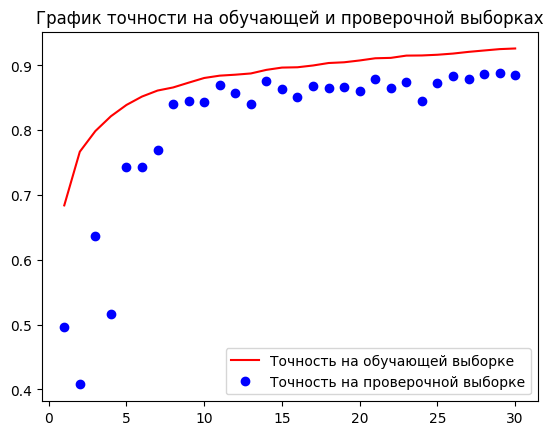

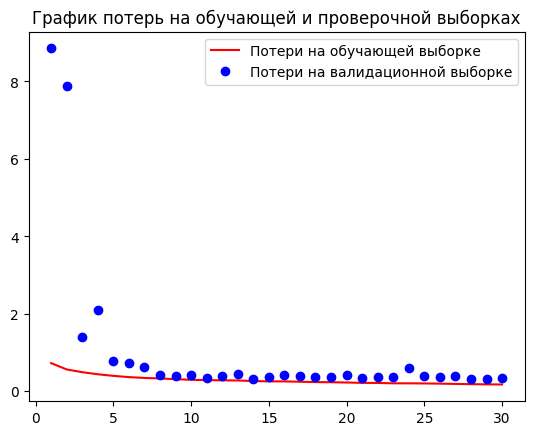

In [ ]:
acc = history.history['sparse_categorical_accuracy']                       # данные о точности на обучающей выборке
val_acc = history.history['val_sparse_categorical_accuracy']               # данные о точности на проверочной выборке
loss = history.history['loss']                                             # данные об ошибке на обучающей выборке
val_loss = history.history['val_loss']                                     # данные об ошибке на проверочной выборке
epochs = range(1, len(acc) + 1)                                            # массив со значениями для оси абсцисс (Х)
plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')          #  строим график точность на обучающей выборке
plt.plot(epochs, val_acc, 'bo', label='Точность на проверочной выборке')   #  строим график точность на проверочной выборке
plt.title('График точности на обучающей и проверочной выборках')           #  заголовок графика
plt.legend()                                                               #  легенда графика
plt.figure()                                                               #  создаем новую фигуру (полотно для графика)
plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')           #  строим график потерь (ошибки) на обучающей выборке
plt.plot(epochs, val_loss, 'bo', label='Потери на валидационной выборке')  #  строим график потерь на проверочной выборке
plt.title('График потерь на обучающей и проверочной выборках')             #  заголовок графика
plt.legend()                                                               #  легенда графика
plt.show()

В целом результат неплохой. Даже на тестовой выборке был достигнут результат точности почти 90%.

### Визуальная оценка результата сегментации на тестовой выборке

Сравним оригинальную маску и предсказанную маску на тестовой выборке. Для этого немного поправим функцию `display`.

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Входное изображение', 'Оригинальная маска', 'Предсказанная маска']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[0]))            # отображаем картинку
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]),alpha=0.5)  # отображаем маску с прозрачностью 50%
    plt.axis('off')
  plt.show()

Определим функцию создания маски и отобразим 12 образцов изображений, а также соответствующих им оригинальные и предсказанные маски.

1/1 [==============================] - 0s 156ms/step


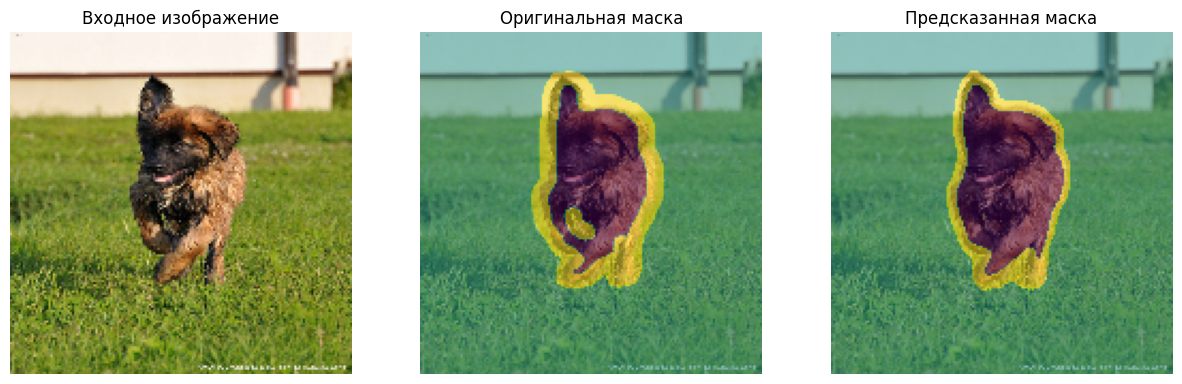

1/1 [==============================] - 0s 69ms/step


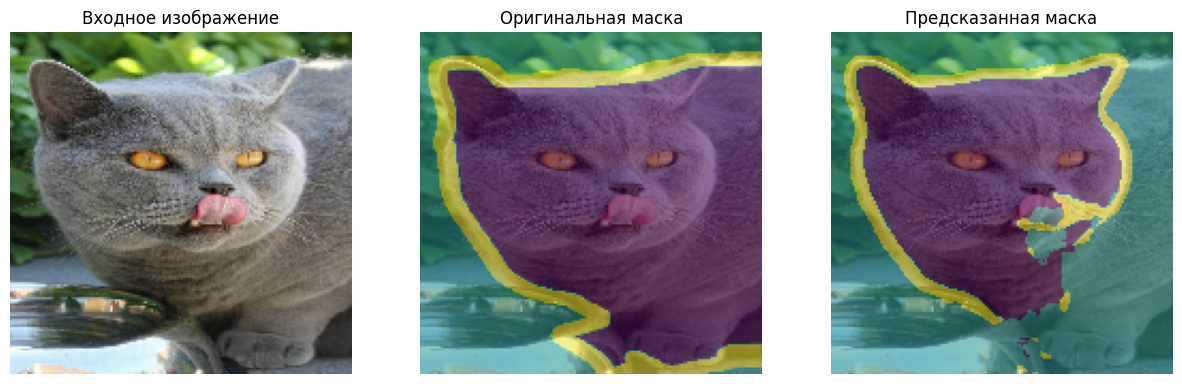

1/1 [==============================] - 0s 113ms/step


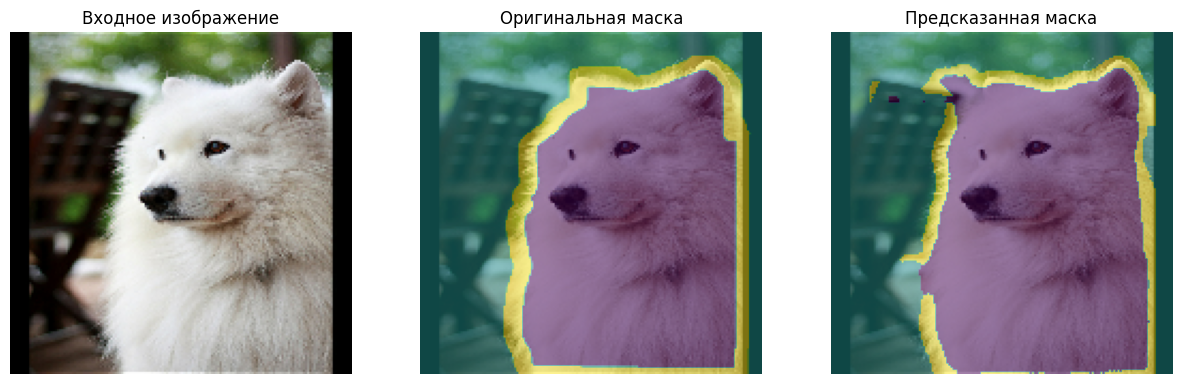

1/1 [==============================] - 0s 112ms/step


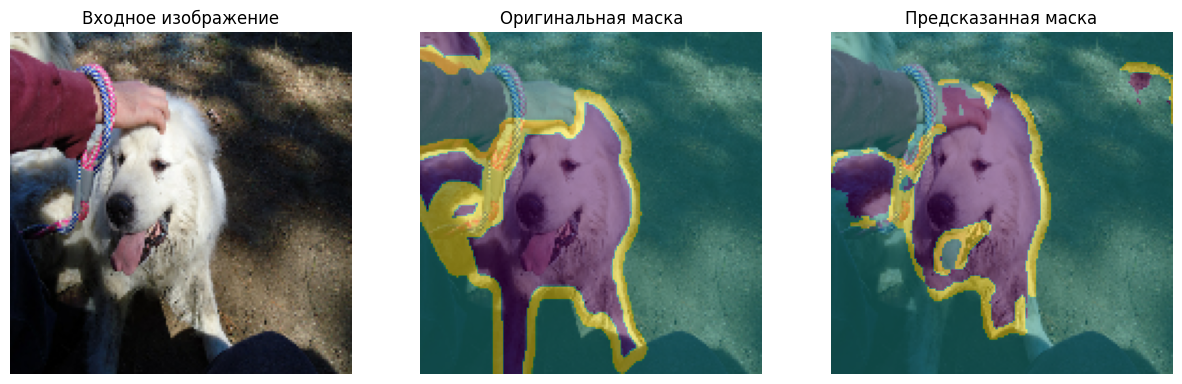

1/1 [==============================] - 0s 45ms/step


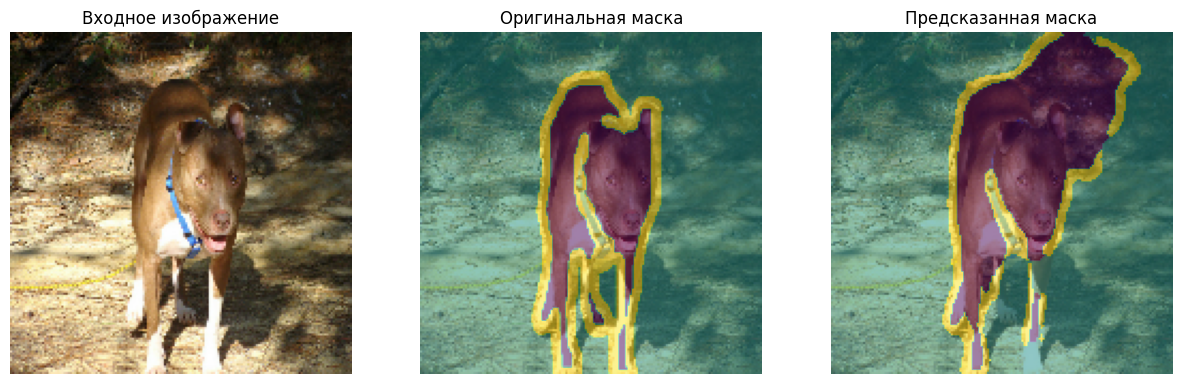

1/1 [==============================] - 0s 50ms/step


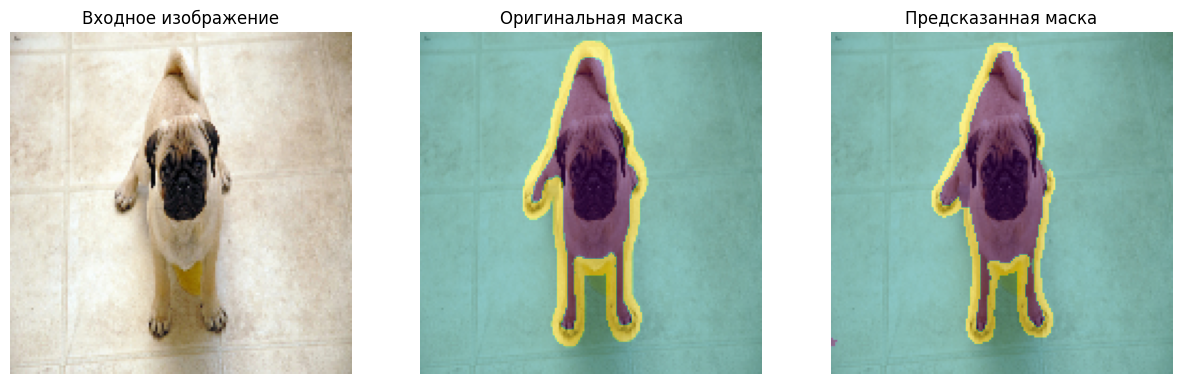

1/1 [==============================] - 0s 44ms/step


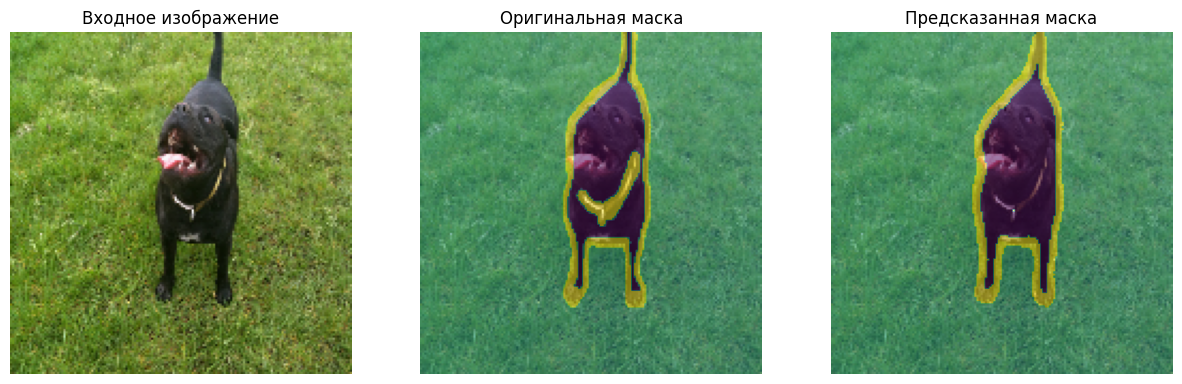

1/1 [==============================] - 0s 66ms/step


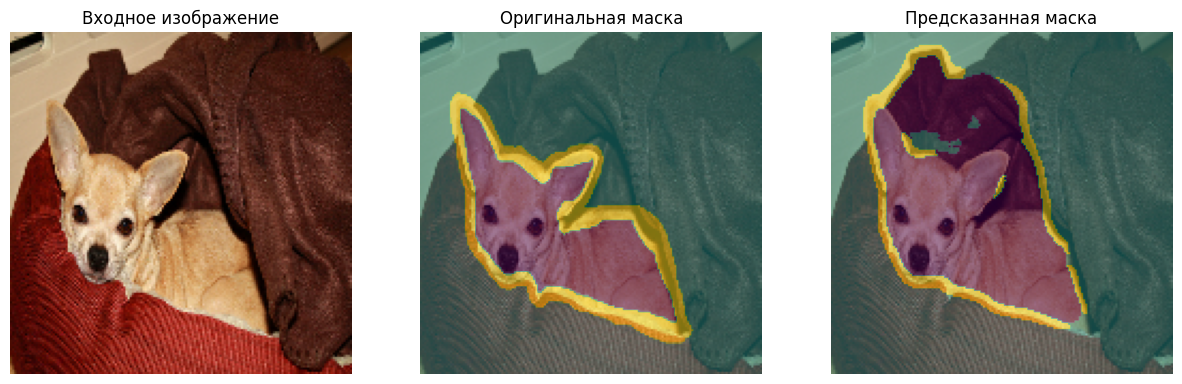

1/1 [==============================] - 0s 49ms/step


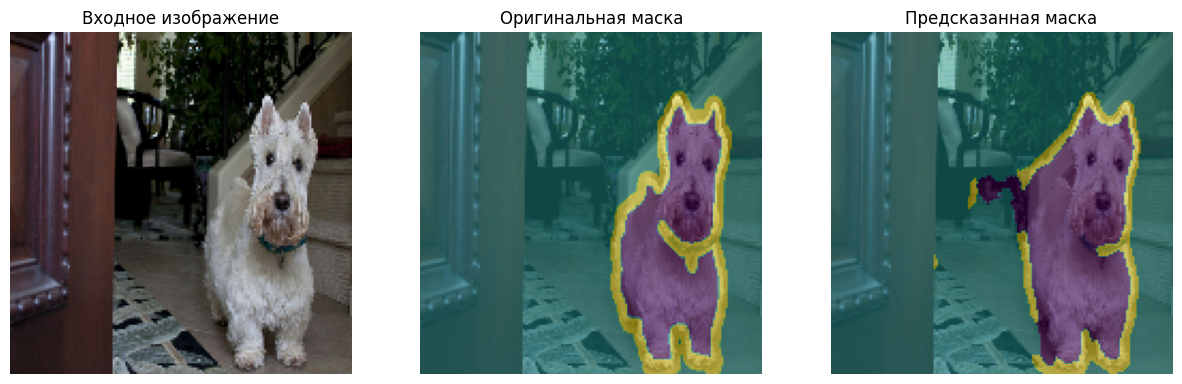

1/1 [==============================] - 0s 73ms/step


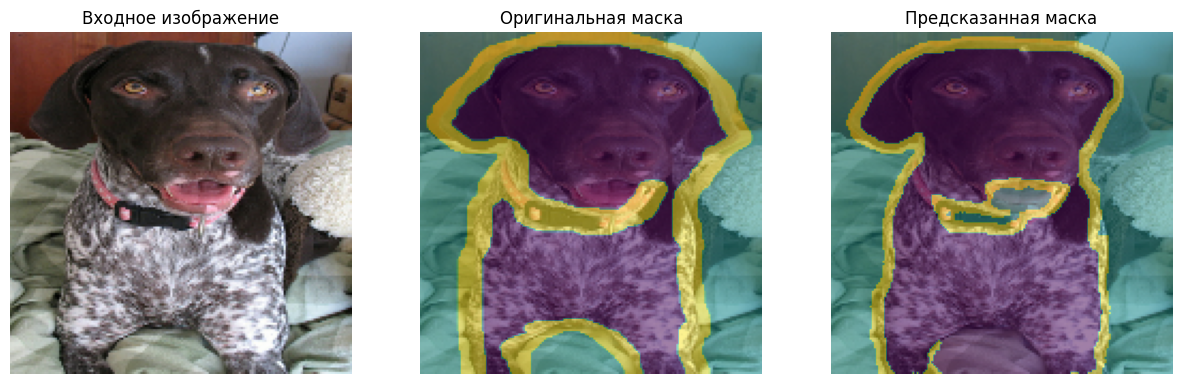

1/1 [==============================] - 0s 41ms/step


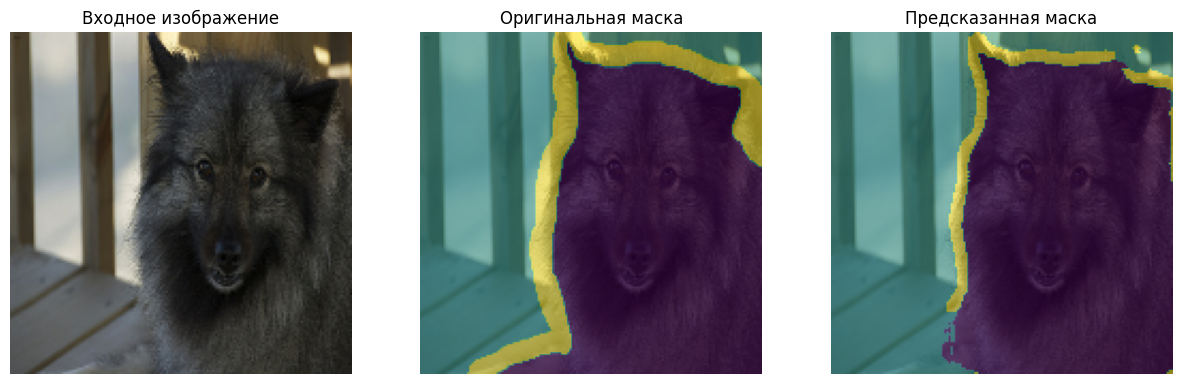

1/1 [==============================] - 0s 35ms/step


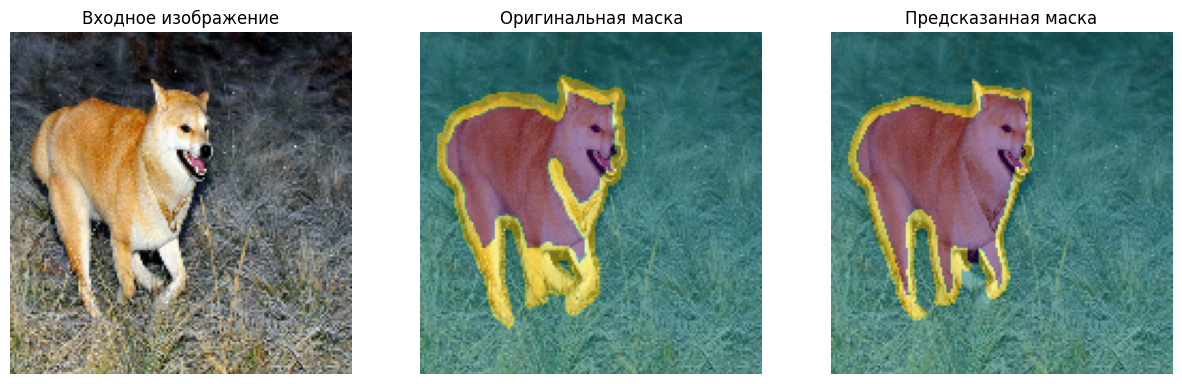

In [ ]:
def create_mask(pred_mask):

    pred_mask = tf.math.argmax(pred_mask, axis=-1)        # индекс аргумента с максимальным значением, вместо вероятности по классам получаем
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


for image, mask in test_images.take(12):                  # выбираем 12 картинок и выводим их в цикле

    pred_mask = model.predict(image[:1])                  # предсказываем маску с помощью обученной модели
    display([image[0], mask[0], create_mask(pred_mask)])  # передаем в функцию display изображение, оригинальную маску и предсказанную

В целом оригинальные маски и предсказанные на тестовой выборке совпадают. Для более качественного результата необходимо провести дополнительную аугментацию изображений. Важно помнить, что если для аугментации изображений применяется процедура трансформации: поворот, растягивание, обрезание, дублирование, отражение и прочее, то маску необходимо аналогичным образом трансформировать. Применять к маске элементы аугментации связанные с интенсивностью пикселей не имеет смысла и даже может быть вредно, так как интенсивности определяют класс маски.

Также для повышения качества сегментации необходимо увеличить число эпох обучения и предусмотреть коллбэк для ранней остановки процесса обучения, если модель перестала обучаться.

А теперь перейдем к [следующей части урока](https://colab.research.google.com/drive/1Fy26vjAZPOVTOh8ZLnUYHiev3jD7J4Sh) и рассмотрим пример мультиклассовой сегментации.